In this project, we will use Convolutional Neural Network ro build trainand test atraffic sign classification model. We will build this model using tensorflow and keras. It is a multiclass classification problem. This model can be used to make smarter cars.

In [1]:
# Run this cell and select the kaggle.json file dowloaded from the Kaggle account setting page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mahoorshams","key":"2b5ec3a9e9700362b646e3b095c12b8d"}'}

We will start by connecting to Kaggle API which can be downloaded from your Kaggle account's setting and uploading it here(upload box)

In [2]:
# Install the Kaggle API client
!pip install -q kaggle

Installing kaggle API using pip.

In [3]:
# The Kaggle API client expects this file to be in ~/.kaggle, so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This premission change avoids a warning on kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Setting up Kaggle using Kaggle API.

In [4]:
# Creating directory and changing the current working directory.
!mkdir traffic_sign_dataset
%cd traffic_sign_dataset

/content/traffic_sign_dataset


To store the data we will create a new directory and make it as current working directory.

In [5]:
# Searching for dataset
!kaggle datasets list -s gtsrb-german-traffic-sign

ref                                                                title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meowmeowmeowmeowmeow/gtsrb-german-traffic-sign                     GTSRB - German Traffic Sign Recognition Benchmark  612MB  2018-11-25 18:12:34         127121       1176  0.8235294        
valentynsichkar/traffic-signs-preprocessed                         Traffic Signs Preprocessed                           4GB  2019-08-31 18:22:11          16115        298  1.0              
harbhajansingh21/german-traffic-sign-dataset                       German Traffic Sign Dataset                        118MB  2023-07-11 04:21:24           1704         33  1.0              
ibrahimkaratas/gtsrb-german-traffic-sign-recogniti

Searching Kaggle for the required dataset using serach option(-s) with title 'gtsrb-german-traffic-sign'. We can also use different search options like searching competitions, notebooks, kernels, datasets, etc.

In [9]:
# Downloading dataset and coming out of directory
!kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
%cd ..

Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
gtsrb-german-traffic-sign.zip: Skipping, found more recently modified local copy (use --force to force download)
/content


After searching the data next step would be downloading the data into colab notebook using refrences found in search option.

In [10]:
!ls traffic_sign_dataset

gtsrb-german-traffic-sign.zip


In [11]:
# Unzipping downloaded file and removing unusable file
!unzip traffic_sign_dataset/gtsrb-german-traffic-sign.zip -d traffic_sign_dataset
!rm traffic_sign_dataset/gtsrb-german-traffic-sign.zip
!rm -rf traffic_sign_dataset/Meta
!rm -rf traffic_sign_dataset/meta
!rm -rf traffic_sign_dataset/test
!rm -rf traffic_sign_dataset/train
!rm traffic_sign_dataset/Meta.csv

Streaming output truncated to the last 5000 lines.
  inflating: traffic_sign_dataset/train/5/00005_00053_00010.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00011.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00012.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00013.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00014.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00015.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00016.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00017.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00018.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00019.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00020.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00021.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00022.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00023.png  
  inflating: traffic_sign

We will unzip the data which is downloaded and remove the irrelevan files.

In [33]:
# Important libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, Input

Importing required libraries.

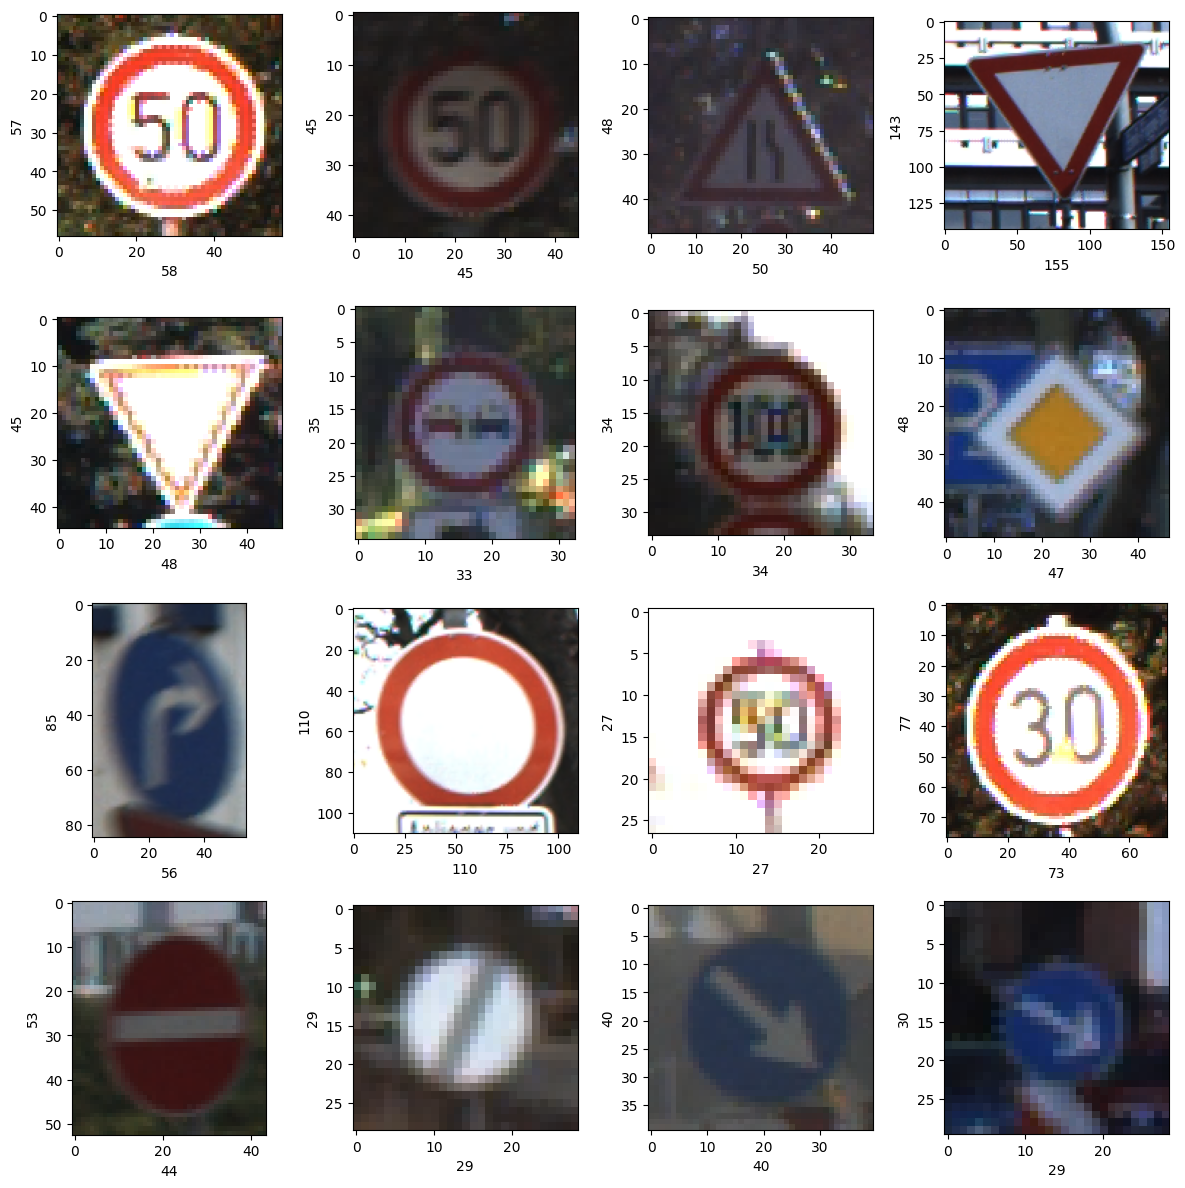

In [13]:
#Plotting 12 images to check dataset
plt.figure(figsize=(12,12))
path="traffic_sign_dataset/Test"
for i in range(1,17):
  plt.subplot(4, 4, i)
  plt.tight_layout()
  rand_img = imread(path + '/' + random.choice(sorted(os.listdir(path))))
  plt.imshow(rand_img)
  plt.xlabel(rand_img.shape[1], fontsize= 10) #Width of image
  plt.ylabel(rand_img.shape[0], fontsize=10)  #Height of image

Visualizing some images of traffic sign from the test dataset. We can see here that the dimension of images are uneven.

In [17]:
train_path = 'traffic_sign_dataset/Train'
classes = os.listdir(train_path)
print(f"Number of classes: {len(classes)}")
print(f"Class labels: {classes}")

Number of classes: 43
Class labels: ['11', '2', '24', '6', '21', '30', '4', '19', '20', '3', '15', '8', '10', '23', '13', '25', '31', '39', '36', '26', '14', '32', '16', '29', '9', '18', '1', '37', '41', '5', '0', '22', '35', '12', '28', '17', '42', '34', '27', '7', '40', '33', '38']


This is a way we can find out the number of classes.

In [15]:
# As size of images are different we have to make them equal so we will take mean of demensions.
dim1 = []
dim2 = []

for i in range(0,43):
  labels = 'traffic_sign_dataset/Train' + '/{0}'.format(i)
  image_path = os.listdir(labels)
  for x in image_path:
    img = imread(labels + '/' + x)
    dim1.append(img.shape[0])
    dim2.append(img.shape[1])

For further processing we will require the images of same dimension. so, we will start sorting the dimention of all images from training dataset from all 43 classes.

In [18]:
# Printing mean dimension of images
print("Dimention 1 Mean : ", np.mean(dim1), " Dimention 2 Mean : ", np.mean(dim2))

Dimention 1 Mean :  50.328929582493814  Dimention 2 Mean :  50.83587951745773


Now we will find out the mean value of both dimetions and analyse them. Here, we can see that(50,50) is the average shape for all the images.



In [21]:
# Now we will reshape the images to (50,50)
images = []
label_id =[]

for i in range(43):
  labels = 'traffic_sign_dataset/Train' + '/{0}'.format(i)
  image_path = os.listdir(labels)
  for x in image_path:
    img = Image.open(labels + '/' + x)
    img = img.resize((50,50))
    img = np.array(img)
    images.append(img)
    label_id.append(i)

Now we will reshape the image into (50,50) and also store their label ids.

In [22]:
# Converting images into numpy array
images = np.array(images)
# The pixel value of each image ranges between 0 and 255
# Dividing each image by 255 will scale the values between 0 and 1. This is also known as Normalization.
images = images/255

Now we will convert all the images into nupmy array and normalize them.

In [24]:
label_id = np.array(label_id)
label_id.shape

(39209,)

Sorting the label ids into numpy array and printing the shape. Here we can observe that their are 39209 label ids.

In [25]:
images.shape

(39209, 50, 50, 3)

Checking the shape of the images. Here we can see that their are 39209 images with a shape of (50,50,3).

In [26]:
# Visualize the number of classes count
label_count = pd.DataFrame(label_id).value_counts()
label_count.head()

,count
0,
2,2250
1,2220
13,2160
12,2100
38,2070


Now we will observe images per class for checking whether the data is balanced or not. From the result we can say that data is balanced.

In [28]:
# Splitting the data
x_train, x_val, y_train, y_val = train_test_split(images, label_id, test_size= 0.2, random_state=42)

The next step would be to split the data into training and validation with 80% of training data and 20% of validation data.

In [31]:
# Keras has a built-in function for one-hot encoding.
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

Converting the classes column into categorical using to_categorical() function.

In [36]:
# model = Sequential()

# model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = x_train.shape[1:], activation = 'relu', padding = 'same'))
# model.add(MaxPool2D(pool_size = (2,2)))
# model.add(Dropout(0.5))

# model.add(Conv2D(filters = 64, kernel_size= (3,3), activation = 'relu'))
# model.add(MaxPool2D(pool_size = (2,2)))
# model.add(Dropout(0.5))

# model.add(Flatten())
# model.add(Dense(128, activation = 'relu'))
# model.add(Dropout(0.5))
# model.add(Dense(43, activation= 'softmax'))


#this wat we got an warning : the warning arises because input_shape is being passed directly to the Conv2D layer, which is now discouraged. Instead, Keras recommends using an Input layer explicitly to define the input shape in Sequential models
#_____________________________


# Define the model
model = Sequential([
    Input(shape=x_train.shape[1:]),  # Define input shape explicitly

    # First Convolutional Block
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.5),

    # Second Convolutional Block
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.5),

    # Fully Connected Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')  # 43 classes for output
])

Defining the model architecture. In this we will define all the layers with their input shape kernel size, activation, etc.

In [38]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics =['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 50, 50, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 23, 23, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 7744)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         991,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 43)                  │           5,547 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,035,627 (3.95 MB)

 Trainable params: 1,035,627 (3.95 MB)

 Non-trainable params: 0 (0.00 B)

Compiling the model using metrics, optimizer and loss as required and printing out the summary of the model.

In [40]:
model.fit(x_train, y_train, epochs = 50, batch_size = 128, validation_data = (x_val, y_val), verbose = 2)

Epoch 1/50


KeyboardInterrupt: 

Now we will fit the model and observe how our model is getting trained on each epoch.